In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.display import clear_output
!pip install -U albumentations --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet
clear_output()

In [3]:
import cv2
import gc
import time
import torch
import pickle
import random
import torchvision
import numpy as np
import torch.nn as nn
from pathlib import Path
import albumentations as A
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import KFold
from skimage.measure import label, regionprops
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

path_tr = '/content/drive/MyDrive/TZ/myte/input/xtrain.npy'
path_mask = '/content/drive/MyDrive/TZ/myte/input/ytrain.npy'
path_test = '/content/drive/MyDrive/TZ/myte/input/xtest.npy'
path_save_model = '/content/drive/MyDrive/TZ/myte/model'
store_dir = '/content/drive/MyDrive/TZ/myte/mlruns'


SEED = 13
DEBUG = False
set_seed(SEED)

In [4]:
def mlflow_colab(store_dir: str) -> None:  
    # run tracking UI in the background
    get_ipython().system_raw(f"mlflow ui --backend-store-uri file:{store_dir} --port 5000 &") # run tracking UI in the background
    # create remote tunnel using ngrok.com to allow local port access
    # borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6
    from pyngrok import ngrok
    # Terminate open tunnels if exist
    ngrok.kill()
    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    NGROK_AUTH_TOKEN = ""
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)


import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient


mlflow_colab(store_dir)
mlflow.set_tracking_uri(f"file:{store_dir}")

MLflow Tracking UI: https://819f-34-122-147-234.ngrok.io


## Load Data

In [5]:
tr = np.load(path_tr)
tr_mask = np.load(path_mask)
tr.shape, tr_mask.shape

((15137, 256, 256, 1), (15137, 8))

In [6]:
def find_bbox(data: list) -> tuple:
    # from skimage.measure import label, regionprops    
    """
    # https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
    Label connected regions of this mask using skimage.measure.label
    Measure morphological properties of these connected regions and keep
    the bounding box (skimage.measure.regionprops). For each connected region
    a bounding box of the form (min_row, min_col, max_row, max_col) is returned.
    
    data: list, mask
    return: tuple, x1, y1, x2, y2
    """
    
    l0 = label(data)
    pr = regionprops(l0)
    return pr[0].bbox[1], pr[0].bbox[0], pr[0].bbox[4], pr[0].bbox[3]


def show_board(image: list, points: list, idx: int) -> None:
    points = points * 255
    make_pair = list([int(i), int(j)] for i, j in zip(points[0::2], points[1::2]))
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)
    fb = find_bbox(mask)
    img = np.squeeze(image)
    mask = np.squeeze(mask)
    masked_image = cv2.bitwise_and(img, mask)
    
    fig, axes = plt.subplots(1,4,figsize=(14,8), sharex=True, sharey=True)

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    axes[2].imshow(masked_image, cmap='gray')
    axes[2].set_title('Mask Image')
    axes[2].axis('off')
    im = img.copy()
    cv2.rectangle(
        im, 
        (int(fb[0]), int(fb[1])),
        (int(fb[2]), int(fb[3])),
        (255,0,0),
        3
    )    
    axes[3].imshow(im, cmap='gray')
    axes[3].set_title('Bbox')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0)
    plt.suptitle(f'Index image: {idx}', y = .75)
    plt.show()

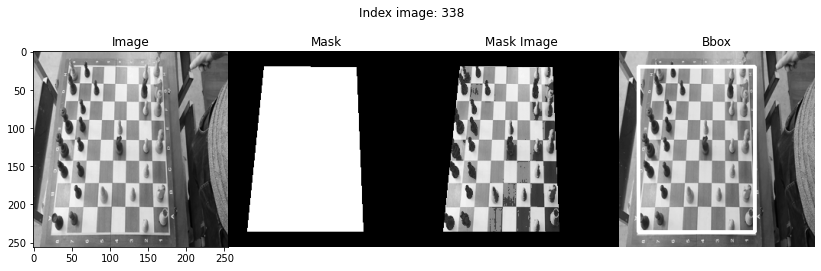

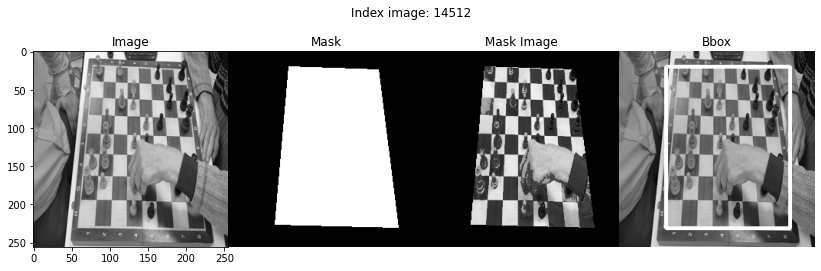

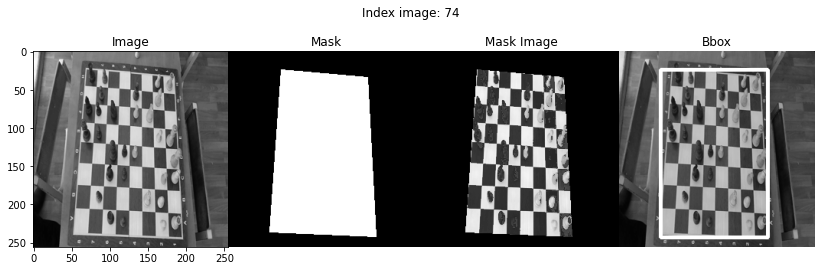

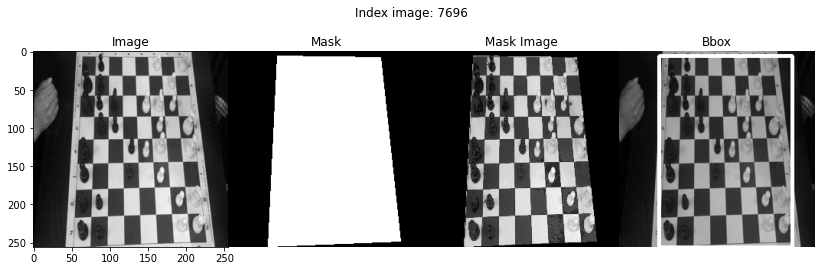

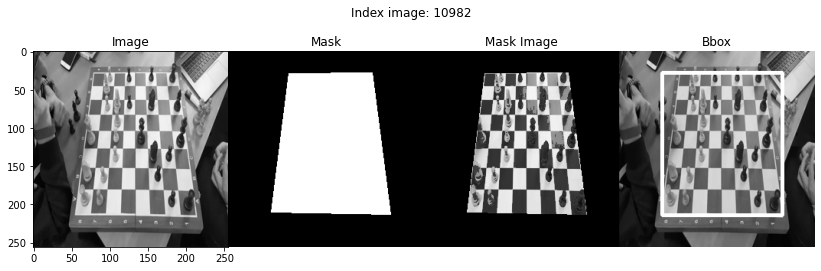

In [7]:
for _ in range(5):
    idx = np.random.choice(tr.shape[0])
    show_board(tr[idx], tr_mask[idx], idx)

## Dataset

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))


class Chess_Dataset(Dataset):

    def __init__(self, data, point, transforms = None):
        self.data = data
        self.point = point
        self.transforms = transforms

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        boxes = []
        target = {}    
        # img = self.data[idx]
        img = np.repeat(self.data[idx], 3, -1)  
        pt = self.point[idx]
        #make mask
        pt = pt * 255
        make_pair = list([int(i), int(j)] for i, j in zip(pt[0::2], pt[1::2]))
        # mask = np.zeros_like(img)
        mask = np.zeros((256, 256), dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]       
        # find bbox by mask
        pos = np.where(np.array(mask) > 0)           
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin , ymin, xmax , ymax  ])
        if self.transforms:
            sample = {
                'image': img,
                'masks': [masks],
                'bboxes':boxes,
                'labels': [str(1)]
                }
            sample = self.transforms(**sample)
            img = sample['image']
            masks = sample['masks']
            bboxes = sample['bboxes']
        img = img / 255.0     
        img = img.transpose(2, 0, 1).astype(np.float32)
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['masks'] = torch.as_tensor(masks, dtype=torch.uint8)
        target['boxes'] = boxes
        target['area'] = area   
        target['image_id'] = torch.tensor([idx], dtype = torch.float16)  
        target['labels'] = torch.ones(1, dtype = torch.long)      
        target['iscrowd'] = torch.zeros(1, dtype=torch.long) 
        return torch.tensor(img, dtype = torch.float32), target


class Chess_Dataset_test(Dataset):

    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):         
        img = np.repeat(self.data[idx], 3, -1)
        img = img / 255.0
        img = np.transpose(img, (2,0,1))
        if self.transforms is not None:
            img = self.transforms(img)        
        return torch.tensor(img, dtype = torch.float32), idx

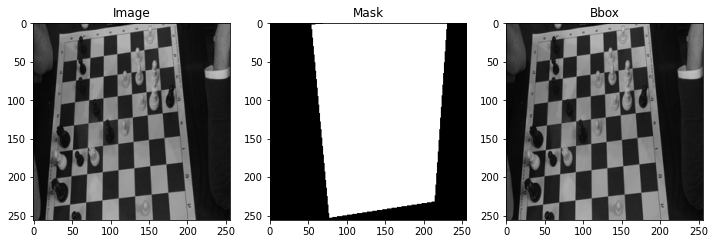

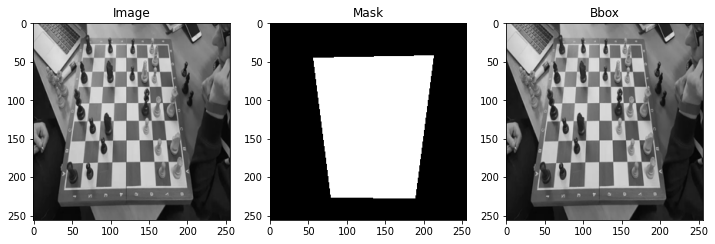

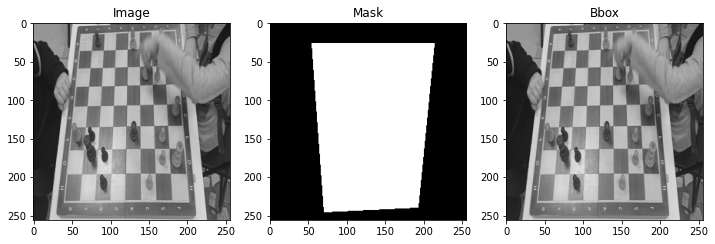

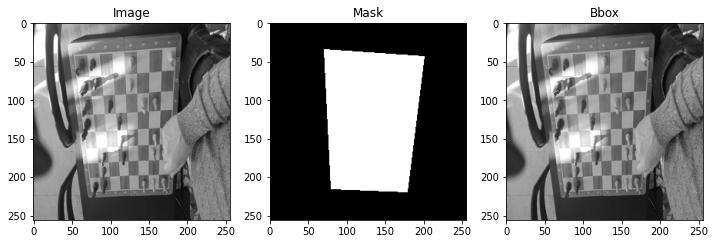

In [9]:
def tr_transform():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ],
                   bbox_params=A.BboxParams(format='pascal_voc', 
                                            label_fields=['labels']
                                            ),
                   )


dataset = Chess_Dataset(tr, tr_mask, tr_transform())
data_loader_mask = DataLoader(dataset,
                              batch_size=2,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=collate_fn)


for _ in range(2):
    image, target = next(iter(data_loader_mask))
    for i, d in enumerate(target):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))
        box = d['boxes'].cpu().numpy() * 256
        mask = d['masks'].cpu().numpy()
        im = image[i].cpu().numpy()   
        im  = np.transpose((im * 255).astype(np.uint8), (1,2,0))
        im = np.squeeze(im)
        mask = np.squeeze(mask)
        im_ori = im.copy()
        for bx in box:
            cv2.rectangle(
            im,
            (int(bx[0]), int(bx[1])),
            (int(bx[2]), int(bx[3])),
            (0,0,0), 2
            )
        ax1.imshow(im_ori, cmap='gray')
        ax1.set_title('Image')
        ax2.imshow(mask, cmap='gray')
        ax2.set_title('Mask')
        ax3.imshow(im, cmap='gray')
        ax3.set_title('Bbox')

## Model

In [10]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


class CHESS_NET_MASK(nn.Module):

    def __init__(self, num_classes: int = 2, test :bool = False):
        super().__init__()
        hidden_layer = 256
        self.test = test
        if self.test:
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(
                pretrained=False,
                pretrained_backbone=False
            )
        else:
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)

        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels       
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask,
            hidden_layer,
            num_classes
        )
    
    def forward(self, x, y = None):
        if self.test:      
            return self.model(x)
        else:
            assert y is not None, f'target error PT_RRCNN_MASK, y : {y}'
            return self.model(x, y)

##Train&valid Loop

In [11]:
def help_track_param(
    optimizer: torch.optim,
    scheduler: torch.optim, 
    group_param_opt: list
) -> dict:
    """
    help mlflow
    get param from optimizer by group_param_opt
    save scheduler param to file and load to .log_artifact, once
    return: dict
    """
    param = {k:optimizer.param_groups[0][k] for k in optimizer.param_groups[0].keys() if k in group_param_opt}
    param.update({'optimizer': optimizer.__class__.__name__})   
    name_file = 'scheduler.txt'
    path = Path("/content/sche1duler.txt")
    if scheduler is not None:
        if not path.is_file():
            with open(name_file, 'w') as f:
                print(scheduler.__dict__, file=f)
            mlflow.log_artifact(name_file, artifact_path='scheduler') 
        param.update({'scheduler': scheduler.__class__.__name__}) 
    else:
        param.update({'scheduler': None})
    return param


def train(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim,
) -> float:
    model.train()
    losses, loss_cl, lbr, loss_msk, loss_obj, loss_rbg  = [],[],[],[],[],[]   
    for images, targets in tqdm(loader):     
        optimizer.zero_grad()   
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]       
        loss_dict = model(images, targets)
        ls = sum(loss for loss in loss_dict.values())           
        ls.backward()
        optimizer.step()
        """
        loss_dict.items:
                {'loss_classifier': tensor(0.3887, grad_fn=<NllLossBackward>), 
                 'loss_box_reg': tensor(0.3354, grad_fn=<DivBackward0>),
                 'loss_mask': tensor(0.8957, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 
                 'loss_objectness': tensor(0.2001, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 
                 'loss_rpn_box_reg': tensor(0.0172, grad_fn=<DivBackward0>)
                 }
        """    
        dct = {k: v.detach().cpu().numpy() for k, v in loss_dict.items()}
        loss_cl.append(dct['loss_classifier'])
        lbr.append(dct['loss_box_reg'])
        loss_msk.append(dct['loss_mask'])
        loss_obj.append(dct['loss_objectness'])
        loss_rbg.append(dct['loss_rpn_box_reg'])
        losses.append(ls.detach().cpu().numpy())            

 
    print(f'Train: loss_classifier: {np.mean(loss_cl)}, loss_box_reg: {np.mean(lbr)}, loss_mask: {np.mean(loss_msk)}')
    print(f'Train: loss_objectness: {np.mean(loss_obj)}, loss_rpn_box_reg: {np.mean(loss_rbg)}, all loss: {np.mean(losses)}')
    return np.mean(losses)


@torch.no_grad()
def valid(model: nn.Module, loader: DataLoader) -> tuple:
    # batch = 1
    model.eval()
    iou = []
    d_threshold = [.5, .75]
    pr_5, pr_75 = [], []
    for images, targets in tqdm(loader): 
      images = list(image.to(device) for image in images) 
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 
      #cheked need?? https://github.com/pytorch/vision/blob/master/references/detection/engine.py
      if torch.cuda.is_available():
        torch.cuda.synchronize()
      loss_dict = model(images, targets)     
      out = [{k: v.cpu().numpy() for k, v in t.items()} for t in loss_dict]
    l = len(targets[0]['boxes'])       
    b = out[0]['boxes']
    t = targets[0]['boxes'].cpu().numpy() 
    b_l = out[0]['boxes'][:l].astype(int)
    b_l2 = np.sort(b_l, axis=0)
    t2 = np.sort(t, axis=0)
    score = out[0]['scores']   
    for i in range(len(b_l2)):
        """iou by count target"""
        ori_bbox = t2[i]
        iou_calc = calculate_iou(ori_bbox, b_l2[i])            
        iou.append(iou_calc)
    for thr in d_threshold:
        bx = b[score>=thr]
        tp = len(bx[:l])
        fp = len(bx)
        if thr == 0.5:
            if (fp == 0) or (tp == 0):
                pr_5.append(0)
            else:
                pr_5.append(tp/fp)
        else:
            if (fp == 0) or (tp == 0):
                pr_75.append(0)
            else:
                pr_75.append(tp/fp)
    return iou, pr_5, pr_75


def showtime(
    model: nn.Module,
    train_data: list,
    train_mask: list,
    fold: int,
    scheduler: bool = False
) -> None:
    
    tr_data = np.take(train_data, tr_idx[fold], axis=0)
    vl_data = np.take(train_data, vl_idx[fold], axis=0)
    tr_mask = np.take(train_mask, tr_idx[fold], axis=0)
    vl_mask = np.take(train_mask, vl_idx[fold], axis=0)
    print(f'Train: {len(tr_data)}, Val: {len(vl_data)}')
    tr_dataset = Chess_Dataset(tr_data, tr_mask,  tr_transform())
    vl_dataset = Chess_Dataset(vl_data, vl_mask, vl_transform())
    tr_loader = DataLoader(tr_dataset,
                           batch_size=BATCH,
                           shuffle=True,
                           num_workers=2,
                           collate_fn=collate_fn) 
    vl_loader = DataLoader(vl_dataset,
                           batch_size=1,                     
                           num_workers=2,       
                           collate_fn=collate_fn)   
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.90, weight_decay=0.0005)
    if scheduler:
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
    else:
        lr_scheduler = None  
    best_iou = 0       
    for epoch in range(EPOCH):
        tr_loss = train(model, tr_loader, optimizer)  
        iou, pr_5, pr_75 = valid(model, vl_loader)
        iou, pr_5, pr_75= np.mean(iou), np.mean(pr_5), np.mean(pr_75)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch #{epoch}, LR: {lr} <-->pr.05: {pr_5} <-->pr.75: {pr_5} <--> iou: {iou}")
        if iou > best_iou:
            print(f'Save iou: {iou}')
            name = f'{MODEL}_model_{fold}.pth'
            if not DEBUG:
                torch.save(model.state_dict(), Path(path_save_model) / name)   
            best_iou = iou
        if lr_scheduler is not None:
            lr_scheduler.step()
        # checkpoint
        # state_dict = {
        #     "model": model.state_dict(),
        #     "optimizer": optimizer.state_dict(),          
        #     }
        # mlflow.pytorch.log_state_dict(state_dict, artifact_path='checkpoint')        
        gpo = ['momentum', 'weight_decay']  
        param = help_track_param(
            optimizer,
            lr_scheduler,
            gpo
        )
        mlflow.log_params(param)        
        mlflow.log_metrics({
            'lr'         : lr,
            'tr_all_loss': tr_loss,   
            'iou'        : iou,
            'pr5'        : pr_5,
            'pr75'       : pr_75, 
            }
        )

##Make folds

In [12]:
if DEBUG: st = 20
else: st = 200

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
tr_idx = []
vl_idx = []
for f, (trx, vlx) in enumerate(kf.split(tr[:st])):
    print(len(trx), len(vlx))
    tr_idx.append(trx)
    vl_idx.append(vlx)

160 40
160 40
160 40
160 40
160 40


##Train

In [ ]:
artifact_rep = store_dir
exp_name = 'chess_board'
client = MlflowClient()
try:
  experiment_id = client.create_experiment(exp_name, artifact_location=artifact_rep)
except:
  experiment_id = client.get_experiment_by_name(exp_name).experiment_id

In [14]:
def tr_transform():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ],
                   bbox_params=A.BboxParams(format='pascal_voc', 
                                            label_fields=['labels']
                                            ),
                   )


def vl_transform():  
  return A.Compose([],
                   bbox_params=A.BboxParams(format='pascal_voc', 
                                            label_fields=['labels']
                                            ),
                   )


SEED = 13
if DEBUG:EPOCH = 5
else:EPOCH = 10
LR = 0.005
BATCH = 4
for i in range(5):
    f = f'fold: {i + 1}'
    if DEBUG: f += '_DEBUG'
    with mlflow.start_run(experiment_id = experiment_id, run_name = f) as run:
        run_id = run.info.run_uuid
        client.set_tag(
            run_id,
            "mlflow.note.content",
            "Detect chess boards, default test"
        )
        model = CHESS_NET_MASK()
        MODEL = model.__class__.__name__
        params = {
            "seed": SEED, 
            "init_LR": LR,
            'epoch': EPOCH,
            'len_data': st, 
            'barch_size_train': BATCH,
            'model_name': MODEL,
            'fold': i + 1
        }        
        print(MODEL, f)
        showtime(model, tr, tr_mask, i, True)
        mlflow.log_params(params)
        mlflow.pytorch.log_model(model, "model")    
        del model
        gc.collect()
        torch.cuda.empty_cache()
    !rm /content/scheduler.txt

CHESS_NET_MASK fold: 5
Train: 160, Val: 40


  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train: loss_classifier: 0.05274264141917229, loss_box_reg: 0.07279972732067108, loss_mask: 0.007503642700612545
Train: loss_objectness: 0.009330554865300655, loss_rpn_box_reg: 0.004050870891660452, all loss: 0.1464274376630783


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #0, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.7028497159911428
Save iou: 0.7028497159911428


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.013523775152862072, loss_box_reg: 0.031656187027692795, loss_mask: 0.0018320943927392364
Train: loss_objectness: 0.0022185458801686764, loss_rpn_box_reg: 0.0018132796976715326, all loss: 0.051043879240751266


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #1, LR: 0.00375 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.7612022000364935
Save iou: 0.7612022000364935


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.01333132665604353, loss_box_reg: 0.024880418553948402, loss_mask: 0.0006701579550281167
Train: loss_objectness: 0.0015616335440427065, loss_rpn_box_reg: 0.0014829459832981229, all loss: 0.04192648455500603


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #2, LR: 0.0012500000000000005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8690643607312768
Save iou: 0.8690643607312768


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.013845359906554222, loss_box_reg: 0.02299586310982704, loss_mask: 0.0008434729534201324
Train: loss_objectness: 0.0013163003604859114, loss_rpn_box_reg: 0.0013008390087634325, all loss: 0.040301837027072906


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #3, LR: 0.0 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8690643607312768


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.013010658323764801, loss_box_reg: 0.02331245318055153, loss_mask: 0.0006732632173225284
Train: loss_objectness: 0.0015166020020842552, loss_rpn_box_reg: 0.001307950122281909, all loss: 0.03982092812657356


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #4, LR: 0.0012499999999999998 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9004140197844569
Save iou: 0.9004140197844569


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.01406189613044262, loss_box_reg: 0.02476002275943756, loss_mask: 0.0005715928855352104
Train: loss_objectness: 0.0014192009111866355, loss_rpn_box_reg: 0.0012692112941294909, all loss: 0.04208192229270935


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #5, LR: 0.003750000000000003 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8927446822183664


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.012238932773470879, loss_box_reg: 0.020054111257195473, loss_mask: 0.0008014269405975938
Train: loss_objectness: 0.0009941898752003908, loss_rpn_box_reg: 0.0011050651082769036, all loss: 0.03519372269511223


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #6, LR: 0.005000000000000004 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.921780303030303
Save iou: 0.921780303030303


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.010712899267673492, loss_box_reg: 0.016054119914770126, loss_mask: 0.000531120109371841
Train: loss_objectness: 0.0006564143113791943, loss_rpn_box_reg: 0.0008968223119154572, all loss: 0.028851378709077835


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #7, LR: 0.0037500000000000038 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8767638178569228


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.01002731453627348, loss_box_reg: 0.013809023424983025, loss_mask: 0.0005157102714292705
Train: loss_objectness: 0.0005240036989562213, loss_rpn_box_reg: 0.0008733771974220872, all loss: 0.025749433785676956


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #8, LR: 0.0012500000000000028 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9555628272251309
Save iou: 0.9555628272251309


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.009238776750862598, loss_box_reg: 0.011982793919742107, loss_mask: 0.00043392693623900414
Train: loss_objectness: 0.0005406418349593878, loss_rpn_box_reg: 0.0007880943012423813, all loss: 0.022984232753515244


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #9, LR: 0.0 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9555628272251309


2021/09/04 17:05:16 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/04 17:05:16 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/09/04 17:05:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu102) contains a local version label (+cu102). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local

|fold|values|result|
|---|---|---|
|fold 1| 0.966288483||
|fold 2| 0.974668406||
|fold 3| 0.930524061||
|fold 4| 0.954369752||
|fold 5| 0.976926440||
|      |mean:|0.9605|
|      |std: |0.0169|


## Test

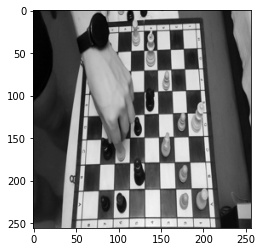

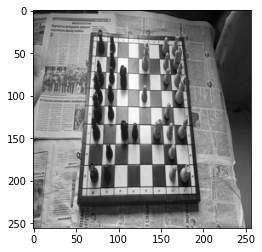

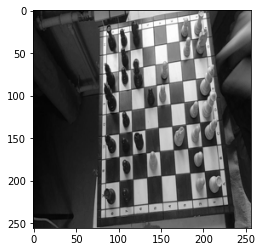

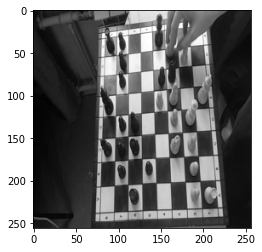

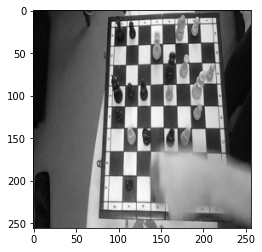

In [16]:
test = np.load(path_test)
for i in range(len(test)):
    image = test[i]
    img = np.squeeze(image)
    plt.imshow(img, cmap='gray')
    plt.show()

In [17]:
dataset_test = Chess_Dataset_test(test)
test_loader =  DataLoader(
    dataset_test,
    batch_size=1,
    num_workers=2,
    collate_fn=collate_fn
)


@torch.no_grad()
def evaluate(name: str, gpu: bool = False) -> list:  
    out = []  
    model = CHESS_NET_MASK(test=True)    
    if gpu:
      model.load_state_dict(torch.load(Path(path_save_model) / name))
    else:
      device = 'cpu'
      model.load_state_dict(torch.load(Path(path_save_model) / name, map_location=device))      
    model.eval()
    model.to(device)
    for images,i  in test_loader:  
        images = list(image.to(device) for image in images)
        if torch.cuda.is_available():
          torch.cuda.synchronize()
        outputs = model(images)
        out.append(outputs)
    return out 

In [18]:
tmp = []
for i in tqdm(range(5)):
  name = f'CHESS_NET_MASK_model_{i}.pth'
  out = evaluate(name)
  # save predict
  if not DEBUG:
    out = list([{v: w.cpu().numpy() for v, w in  out[j][0].items()}] for j in range(len(out)))
    with open(Path(path_save_model) / f'out_predict_{name[:-4]}.pkl', 'wb') as f:
      pickle.dump(out, f)
  tmp.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

##Results

In [19]:
name = f'CHESS_NET_MASK_model_0.pth'
with open(Path(path_save_model) / f'out_predict_{name[:-4]}.pkl', 'rb') as f:
    out = pickle.load(f)

In [20]:
out[0]

[{'boxes': array([[ 58.038925,  16.892725, 210.62152 , 250.02284 ],
         [255.96362 , 226.792   , 256.      , 239.97247 ],
         [ 89.20662 ,  29.709946, 209.25768 , 164.30873 ]], dtype=float32),
  'labels': array([1, 1, 1]),
  'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0.

### One fold

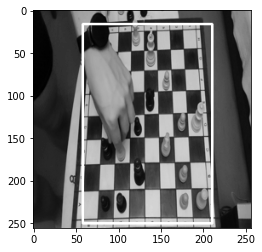

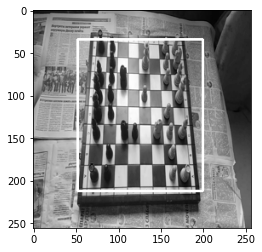

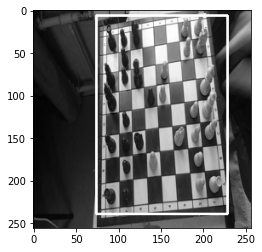

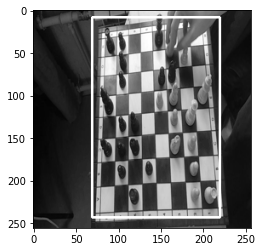

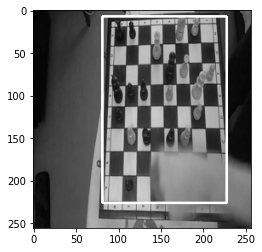

In [21]:
for i in range(5):
  image = test[i]
  img = np.squeeze(image)
  im = img.copy()
  bx = out[i][0]['boxes'][0]
  cv2.rectangle(im,
          (int(bx[0]), int(bx[1])),
          (int(bx[2]), int(bx[3])),
          (255,0,0),
          2)

  plt.imshow(im, cmap='gray')
  plt.show()

### by all Folds

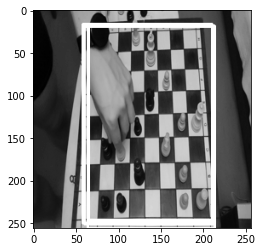

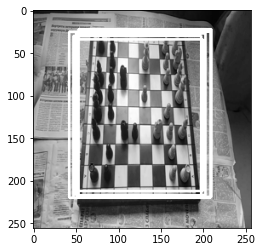

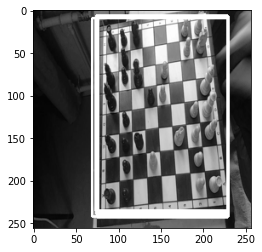

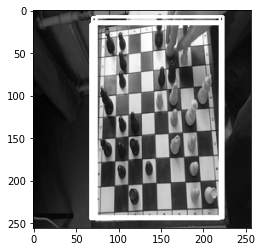

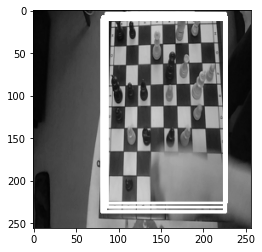

In [22]:
test = np.load(path_test)
detection_threshold = 0.5
for i in range(5):
  #folds  
  name = f'CHESS_NET_MASK_model_{i}.pth'
  with open(Path(path_save_model) / f'out_predict_{name[:-4]}.pkl', 'rb') as f:
    out = pickle.load(f)
  for j in range(5):
    #images
    im = test[j]
    im = np.squeeze(im)
    s = out[j][0]['scores']
    b = out[j][0]['boxes']
    bx = b[s >= detection_threshold]
    cv2.rectangle(
        im,
        (int(bx[0][0]), int(bx[0][1])),
        (int(bx[0][2]), int(bx[0][3])),
        (255,0,0),
        2
    )

    
for i in range(5):
  image = test[i]
  im = np.squeeze(image)
  plt.imshow(im, cmap='gray')
  plt.show()